In [1]:
%autosave 0

Autosave disabled


In [2]:
import timeit
import tensorflow as tf

2023-11-15 15:01:58.955225: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import os  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

In [70]:
start_time = timeit.timeit()

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

2023-11-15 16:55:36.694322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 16:55:36.694737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 16:55:36.694925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 16:55:36.695157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 16:55:36.695332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

<tf.Tensor: shape=(), dtype=float32, numpy=418.60104>

In [5]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk

print(f"Tensor Flow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.9.1

Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:45:29) 
[GCC 10.4.0]
Pandas 1.4.2
Scikit-Learn 1.3.2
GPU is available


# 8. Neural networks and deep learning

This week, we'll learn about neural nets and build a model
for classifying images of clothes


## 8.1 Fashion classification

Dataset: 

* Full: https://github.com/alexeygrigorev/clothing-dataset
* Small: https://github.com/alexeygrigorev/clothing-dataset-small

Links:

* https://cs231n.github.io/

In [6]:
# !git clone git@github.com:alexeygrigorev/clothing-dataset-small.git

In [7]:
# !pip install scipy scikit-learn

## 8.2 TensorFlow and Keras

* Installing TensorFlow
* Loading images

In [8]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
from tensorflow.keras.preprocessing.image import load_img

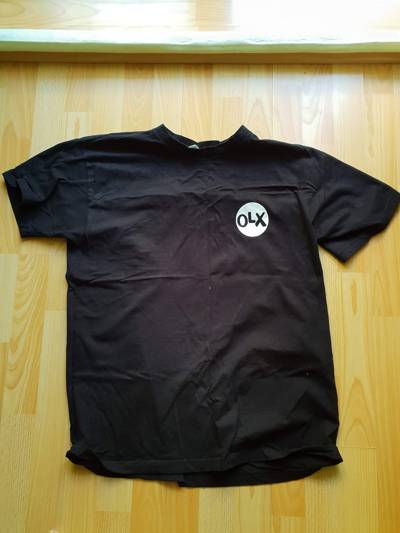

In [11]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [12]:
img = load_img(fullname, target_size=(299, 299))

In [13]:
x = np.array(img)
x.shape

(299, 299, 3)

## 8.3 Pre-trained convolutional neural networks

* Imagenet dataset: https://www.image-net.org/
* Pre-trained models: https://keras.io/api/applications/


In [14]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [15]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

In [16]:
X = np.array([x])

In [17]:
X.shape

(1, 299, 299, 3)

In [18]:
X = preprocess_input(X)

In [19]:
pred = model.predict(X)

1/1 [==============================] - 1s 946ms/step


In [20]:
decode_predictions(pred)

[[('n03595614', 'jersey', 0.6792451),
  ('n02916936', 'bulletproof_vest', 0.03960026),
  ('n04370456', 'sweatshirt', 0.035299566),
  ('n03710637', 'maillot', 0.010884127),
  ('n04525038', 'velvet', 0.0018057587)]]

## 8.4 Convolutional neural networks

* Types of layers: convolutional and dense 
* Convolutional layers and filters
* Dense layers

There are more layers. Read here: https://cs231n.github.io/

## 8.5 Transfer learning

* Reading data with `ImageDataGenerator`
* Train `Xception` on smaller images (150x150)

(Better to run it with a GPU)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

Found 3068 images belonging to 10 classes.


In [23]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [24]:
X, y = next(train_ds)

In [25]:
y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [26]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 341 images belonging to 10 classes.


In [27]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False



inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [28]:
%timeit

learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [29]:
%timeit

history = model.fit(train_ds, epochs=10, validation_data=val_ds)
# 2mins

Epoch 1/10
96/96 [==============================] - 19s 164ms/step - loss: 1.2666 - accuracy: 0.6620 - val_loss: 0.9025 - val_accuracy: 0.7537
Epoch 2/10
96/96 [==============================] - 12s 125ms/step - loss: 0.5314 - accuracy: 0.8305 - val_loss: 0.8038 - val_accuracy: 0.8123
Epoch 3/10
96/96 [==============================] - 12s 125ms/step - loss: 0.3223 - accuracy: 0.8902 - val_loss: 0.8295 - val_accuracy: 0.7830
Epoch 4/10
96/96 [==============================] - 12s 127ms/step - loss: 0.2191 - accuracy: 0.9224 - val_loss: 0.9117 - val_accuracy: 0.7771
Epoch 5/10
96/96 [==============================] - 12s 124ms/step - loss: 0.1674 - accuracy: 0.9413 - val_loss: 0.8229 - val_accuracy: 0.7977
Epoch 6/10
96/96 [==============================] - 12s 123ms/step - loss: 0.1161 - accuracy: 0.9625 - val_loss: 0.9552 - val_accuracy: 0.7830
Epoch 7/10
96/96 [==============================] - 12s 123ms/step - loss: 0.0817 - accuracy: 0.9749 - val_loss: 0.9070 - val_accuracy: 0.8006

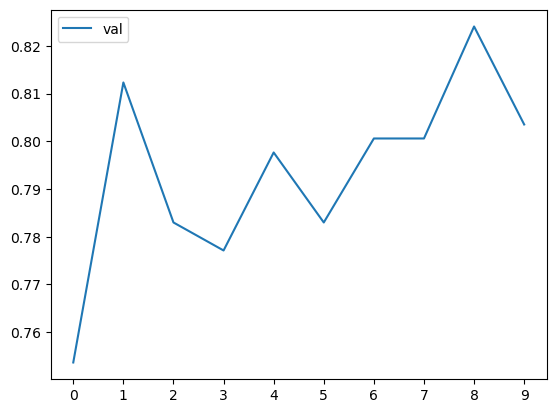

In [30]:
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## 8.6 Adjusting the learning rate

* What's the learning rate
* Trying different values

In [31]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [32]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()
    
# 8mins

0.0001
Epoch 1/10
96/96 [==============================] - 15s 130ms/step - loss: 2.0138 - accuracy: 0.3272 - val_loss: 1.6784 - val_accuracy: 0.4809
Epoch 2/10
96/96 [==============================] - 12s 121ms/step - loss: 1.4194 - accuracy: 0.5603 - val_loss: 1.2880 - val_accuracy: 0.5982
Epoch 3/10
96/96 [==============================] - 12s 121ms/step - loss: 1.1545 - accuracy: 0.6512 - val_loss: 1.0887 - val_accuracy: 0.6804
Epoch 4/10
96/96 [==============================] - 12s 122ms/step - loss: 1.0056 - accuracy: 0.6956 - val_loss: 0.9683 - val_accuracy: 0.7126
Epoch 5/10
96/96 [==============================] - 12s 122ms/step - loss: 0.9096 - accuracy: 0.7190 - val_loss: 0.8893 - val_accuracy: 0.7273
Epoch 6/10
96/96 [==============================] - 12s 121ms/step - loss: 0.8403 - accuracy: 0.7366 - val_loss: 0.8337 - val_accuracy: 0.7507
Epoch 7/10
96/96 [==============================] - 12s 121ms/step - loss: 0.7880 - accuracy: 0.7490 - val_loss: 0.7940 - val_accuracy:

In [33]:
del scores[0.1]
del scores[0.0001]

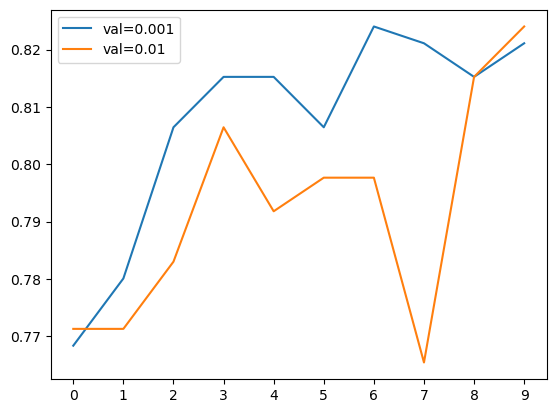

In [34]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [35]:
learning_rate = 0.001

## 8.7 Checkpointing

* Saving the best model only
* Training a model with callbacks

In [36]:
model.save_weights('model_v1.h5', save_format='h5')

In [37]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [38]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[chechpoint]
)
# 2mins

Epoch 1/10
96/96 [==============================] - 15s 132ms/step - loss: 1.0919 - accuracy: 0.6301 - val_loss: 0.7094 - val_accuracy: 0.7771
Epoch 2/10
96/96 [==============================] - 12s 124ms/step - loss: 0.6314 - accuracy: 0.7842 - val_loss: 0.6198 - val_accuracy: 0.8065
Epoch 3/10
96/96 [==============================] - 12s 121ms/step - loss: 0.5125 - accuracy: 0.8325 - val_loss: 0.5947 - val_accuracy: 0.7918
Epoch 4/10
96/96 [==============================] - 12s 123ms/step - loss: 0.4325 - accuracy: 0.8595 - val_loss: 0.5652 - val_accuracy: 0.8211
Epoch 5/10
96/96 [==============================] - 12s 123ms/step - loss: 0.3792 - accuracy: 0.8840 - val_loss: 0.5467 - val_accuracy: 0.8328
Epoch 6/10
96/96 [==============================] - 12s 121ms/step - loss: 0.3287 - accuracy: 0.9032 - val_loss: 0.5416 - val_accuracy: 0.8211
Epoch 7/10
96/96 [==============================] - 12s 120ms/step - loss: 0.2902 - accuracy: 0.9188 - val_loss: 0.5368 - val_accuracy: 0.8240

## 8.8 Adding more layers


* Adding one inner dense layer
* Experimenting with different sizes of inner layer

In [39]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(10)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [40]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

# 6mins

10
Epoch 1/10
96/96 [==============================] - 14s 129ms/step - loss: 1.4675 - accuracy: 0.4866 - val_loss: 0.9948 - val_accuracy: 0.6569
Epoch 2/10
96/96 [==============================] - 12s 120ms/step - loss: 0.8712 - accuracy: 0.7119 - val_loss: 0.7810 - val_accuracy: 0.7537
Epoch 3/10
96/96 [==============================] - 12s 120ms/step - loss: 0.6784 - accuracy: 0.7715 - val_loss: 0.6953 - val_accuracy: 0.7801
Epoch 4/10
96/96 [==============================] - 11s 118ms/step - loss: 0.5443 - accuracy: 0.8240 - val_loss: 0.6247 - val_accuracy: 0.7889
Epoch 5/10
96/96 [==============================] - 11s 118ms/step - loss: 0.4608 - accuracy: 0.8481 - val_loss: 0.6138 - val_accuracy: 0.7830
Epoch 6/10
96/96 [==============================] - 12s 122ms/step - loss: 0.3954 - accuracy: 0.8771 - val_loss: 0.5890 - val_accuracy: 0.7977
Epoch 7/10
96/96 [==============================] - 12s 120ms/step - loss: 0.3385 - accuracy: 0.9045 - val_loss: 0.6350 - val_accuracy: 0.7

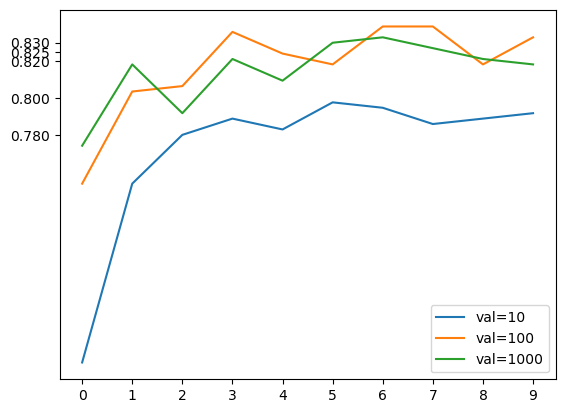

In [41]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

## 8.9 Regularization and dropout

* Regularizing by freezing a part of the network
* Adding dropout to our model
* Experimenting with different values

In [42]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [43]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

# 24mins

0.0
Epoch 1/30
96/96 [==============================] - 15s 130ms/step - loss: 0.9687 - accuracy: 0.6626 - val_loss: 0.6294 - val_accuracy: 0.8006
Epoch 2/30
96/96 [==============================] - 12s 121ms/step - loss: 0.5130 - accuracy: 0.8175 - val_loss: 0.6349 - val_accuracy: 0.7947
Epoch 3/30
96/96 [==============================] - 12s 122ms/step - loss: 0.3635 - accuracy: 0.8781 - val_loss: 0.6672 - val_accuracy: 0.7947
Epoch 4/30
96/96 [==============================] - 12s 121ms/step - loss: 0.2548 - accuracy: 0.9211 - val_loss: 0.5779 - val_accuracy: 0.8240
Epoch 5/30
96/96 [==============================] - 12s 121ms/step - loss: 0.1797 - accuracy: 0.9492 - val_loss: 0.6174 - val_accuracy: 0.8094
Epoch 6/30
96/96 [==============================] - 12s 122ms/step - loss: 0.1289 - accuracy: 0.9726 - val_loss: 0.6067 - val_accuracy: 0.8094
Epoch 7/30
96/96 [==============================] - 12s 121ms/step - loss: 0.0908 - accuracy: 0.9837 - val_loss: 0.6274 - val_accuracy: 0.

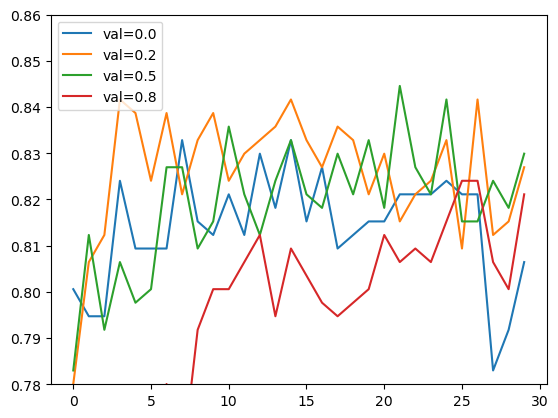

In [44]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.78, 0.86)
plt.legend()

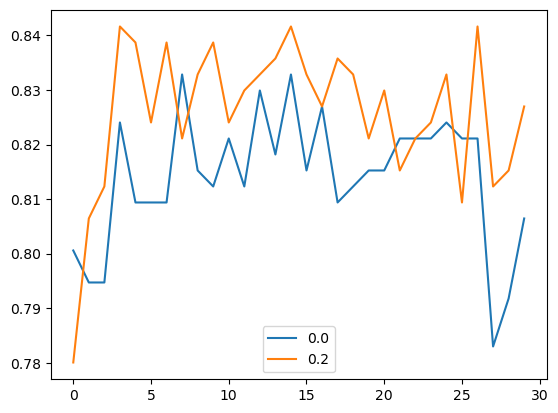

In [45]:
hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()
#plt.plot(hist['accuracy'], label=('val=%s' % droprate))

## 8.10 Data augmentation

* Different data augmentations
* Training a model with augmentations
* How to select data augmentations?

In [46]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     vertical_flip=True,
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [47]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)
# 10mins

Epoch 1/50
96/96 [==============================] - 14s 128ms/step - loss: 1.0856 - accuracy: 0.6346 - val_loss: 0.7028 - val_accuracy: 0.7595
Epoch 2/50
96/96 [==============================] - 11s 119ms/step - loss: 0.6250 - accuracy: 0.7855 - val_loss: 0.6242 - val_accuracy: 0.8006
Epoch 3/50
96/96 [==============================] - 12s 120ms/step - loss: 0.4636 - accuracy: 0.8387 - val_loss: 0.5900 - val_accuracy: 0.7801
Epoch 4/50
96/96 [==============================] - 12s 120ms/step - loss: 0.3808 - accuracy: 0.8703 - val_loss: 0.5808 - val_accuracy: 0.8182
Epoch 5/50
96/96 [==============================] - 12s 120ms/step - loss: 0.2825 - accuracy: 0.9055 - val_loss: 0.5490 - val_accuracy: 0.8328
Epoch 6/50
96/96 [==============================] - 12s 121ms/step - loss: 0.2333 - accuracy: 0.9270 - val_loss: 0.5378 - val_accuracy: 0.8182
Epoch 7/50
96/96 [==============================] - 12s 121ms/step - loss: 0.1927 - accuracy: 0.9404 - val_loss: 0.5367 - val_accuracy: 0.8299

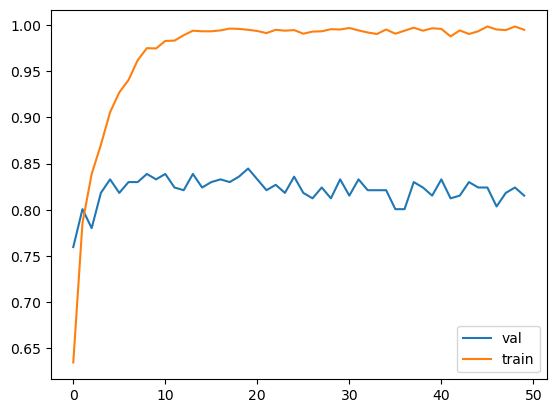

In [48]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

## 8.11 Training a larger model

* Train a 299x299 model

In [49]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [50]:
input_size = 299

In [51]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [52]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [53]:
learning_rate = 0.0005
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])
# 54mins

Epoch 1/50
96/96 [==============================] - 72s 717ms/step - loss: 0.9765 - accuracy: 0.6923 - val_loss: 0.5559 - val_accuracy: 0.8328
Epoch 2/50
96/96 [==============================] - 66s 687ms/step - loss: 0.5300 - accuracy: 0.8211 - val_loss: 0.4730 - val_accuracy: 0.8358
Epoch 3/50
96/96 [==============================] - 66s 688ms/step - loss: 0.4415 - accuracy: 0.8478 - val_loss: 0.4265 - val_accuracy: 0.8534
Epoch 4/50
96/96 [==============================] - 66s 687ms/step - loss: 0.3775 - accuracy: 0.8683 - val_loss: 0.4020 - val_accuracy: 0.8622
Epoch 5/50
96/96 [==============================] - 66s 685ms/step - loss: 0.3519 - accuracy: 0.8840 - val_loss: 0.4156 - val_accuracy: 0.8592
Epoch 6/50
96/96 [==============================] - 66s 688ms/step - loss: 0.3234 - accuracy: 0.8921 - val_loss: 0.3531 - val_accuracy: 0.8710
Epoch 7/50
96/96 [==============================] - 66s 691ms/step - loss: 0.2966 - accuracy: 0.9022 - val_loss: 0.3869 - val_accuracy: 0.8622

## 8.12 Using the model

* Loading the model
* Evaluating the model
* Getting predictions

In [54]:
import tensorflow as tf
from tensorflow import keras

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import preprocess_input

In [56]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 372 images belonging to 10 classes.


In [58]:
model = keras.models.load_model('xception_v4_1_42_0.903.h5')

In [59]:
model.evaluate(test_ds)

12/12 [==============================] - 4s 275ms/step - loss: 0.2870 - accuracy: 0.9005


[0.2869860529899597, 0.9005376100540161]

In [60]:
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'

In [61]:
img = load_img(path, target_size=(299, 299))

In [62]:
import numpy as np

In [63]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [64]:
X = preprocess_input(X)

In [65]:
pred = model.predict(X)

1/1 [==============================] - 1s 611ms/step


In [66]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

In [67]:
dict(zip(classes, pred[0]))

{'dress': -5.1452303,
 'hat': -7.67467,
 'longsleeve': -3.5660844,
 'outwear': -5.061204,
 'pants': 12.539457,
 'shirt': -3.0724034,
 'shoes': -6.115293,
 'shorts': 3.7342205,
 'skirt': -5.9226074,
 't-shirt': -6.746527}

In [71]:
# Run the op several times.
print('Time (s) to run notebook in Colab with T4 hosted runtime.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to run notebook in Colab with T4 hosted runtime.
CPU (s):
0.7389751470036572
GPU (s):
0.03284859500126913
GPU speedup over CPU: 22x


In [72]:
import datetime

def days_hours_minutes(td):
    return td.seconds//3600, (td.seconds//60)%60

elapsed = timeit.default_timer() - start_time
hours, mins = days_hours_minutes(datetime.timedelta(seconds=elapsed))

print(f"The saturn notebook completion time  is : {hours} hours and {mins} minutes")

The saturn notebook completion time  is : 5 hours and 43 minutes


## 8.13 Summary

* We can use pre-trained models for general image classification
* Convolutional layers let us turn an image into a vector
* Dense layers use the vector to make the predictions
* Instead of training a model from scratch, we can use transfer learning and re-use already trained convolutional layers
* First, train a small model (150x150) before training a big one (299x299)
* Learning rate - how fast the model trians. Fast learners aren't always best ones
* We can save the best model using callbacks and checkpointing
* To avoid overfitting, use dropout and augmentation

## 8.14 Explore more

* Add more data, e.g. Zalando, etc (ADD LINKS)
* Albumentations - another way of generating augmentations
* Use PyTorch or MXNet instead of TensorFlow/Keras
* In addition to Xception, there are others architectures - try them 

Other projects:

* cats vs dogs
* Hotdog vs not hotdog
* Category of images

